In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv


In [3]:
faces = pd.read_csv("/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv")
faces.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
faces.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [5]:
faces['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [7]:
from keras.models import Sequential
from keras.layers import BatchNormalization,Conv2D,Dense,Dropout,AvgPool2D,Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [8]:
Y_all=np.asarray(faces['emotion'])
#X_all=np.asarray(faces.drop(columns=['emotion','Usage']))
lis=[]
for i in range(faces['emotion'].count()):
    lis.append(list(map(lambda x: int(x),faces[' pixels'].loc[i].split())))
X_all=np.asarray(lis)

In [9]:
X_all=X_all.reshape(-1,48,48,1)

In [10]:
X_all.shape

(35887, 48, 48, 1)

In [11]:
Y=np.zeros((X_all.shape[0],7))
for i in range(X_all.shape[0]):
    Y[i][Y_all[i]]=1
Y_all=Y

In [12]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [13]:
def show_img(X_all,Y_all,index):
    print('Actual : ',emotions[np.argmax(Y_all[index])])
    plt.imshow(X_all[index,:,:,0],cmap='gray')

In [14]:
X_train,X_val,Y_train,Y_val=train_test_split(X_all,Y_all,test_size=0.15,random_state=13)

Actual :  Happy


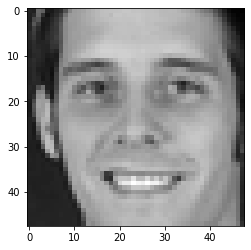

In [16]:
from random import randint
show_img(X_train,Y_train,randint(0,X_train.shape[0]-1))
#show_img(X_all,Y_all,4)

In [17]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(30503, 48, 48, 1)
(5384, 48, 48, 1)
(30503, 7)
(5384, 7)


In [18]:
X_train ,X_val = X_train/255,X_val/255

In [19]:
def create_model():
    
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=16,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=64,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(7,activation='softmax'))
    
    return model

In [20]:
#normal execution
model=create_model()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [22]:
epoch=200
batch_size=256

In [23]:
model.fit(X_train,Y_train,epochs=1)
History=model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),validation_data=(X_val,Y_val),epochs=epoch,steps_per_epoch=X_train.shape[0]//batch_size)

Epoch 1/1
30503/30503 [==============================] - 19s 624us/step - loss: 1.6729 - accuracy: 0.3281
Epoch 1/200
119/119 [==============================] - 13s 109ms/step - loss: 1.4852 - accuracy: 0.4195 - val_loss: 1.3913 - val_accuracy: 0.4627
Epoch 2/200
119/119 [==============================] - 12s 103ms/step - loss: 1.4198 - accuracy: 0.4431 - val_loss: 1.4543 - val_accuracy: 0.4259
Epoch 3/200
119/119 [==============================] - 14s 114ms/step - loss: 1.3763 - accuracy: 0.4660 - val_loss: 1.4810 - val_accuracy: 0.4316
Epoch 4/200
119/119 [==============================] - 13s 105ms/step - loss: 1.3342 - accuracy: 0.4875 - val_loss: 1.2578 - val_accuracy: 0.5191
Epoch 5/200
119/119 [==============================] - 12s 104ms/step - loss: 1.2926 - accuracy: 0.5030 - val_loss: 1.3318 - val_accuracy: 0.4889
Epoch 6/200
119/119 [==============================] - 12s 103ms/step - loss: 1.2579 - accuracy: 0.5202 - val_loss: 1.2366 - val_accuracy: 0.5228
Epoch 7/200
119/11

119/119 [==============================] - 13s 107ms/step - loss: 0.8635 - accuracy: 0.6787 - val_loss: 0.9998 - val_accuracy: 0.6378
Epoch 57/200
119/119 [==============================] - 12s 101ms/step - loss: 0.8599 - accuracy: 0.6826 - val_loss: 0.9981 - val_accuracy: 0.6270
Epoch 58/200
119/119 [==============================] - 12s 104ms/step - loss: 0.8525 - accuracy: 0.6839 - val_loss: 0.9572 - val_accuracy: 0.6436
Epoch 59/200
119/119 [==============================] - 12s 101ms/step - loss: 0.8571 - accuracy: 0.6816 - val_loss: 0.9854 - val_accuracy: 0.6425
Epoch 60/200
119/119 [==============================] - 13s 107ms/step - loss: 0.8439 - accuracy: 0.6894 - val_loss: 0.9696 - val_accuracy: 0.6499
Epoch 61/200
119/119 [==============================] - 13s 109ms/step - loss: 0.8416 - accuracy: 0.6900 - val_loss: 0.9883 - val_accuracy: 0.6395
Epoch 62/200
119/119 [==============================] - 12s 103ms/step - loss: 0.8540 - accuracy: 0.6815 - val_loss: 1.0240 - val_a

Epoch 112/200
119/119 [==============================] - 12s 103ms/step - loss: 0.7472 - accuracy: 0.7245 - val_loss: 0.9838 - val_accuracy: 0.6608
Epoch 113/200
119/119 [==============================] - 13s 113ms/step - loss: 0.7503 - accuracy: 0.7223 - val_loss: 1.0498 - val_accuracy: 0.6421
Epoch 114/200
119/119 [==============================] - 12s 103ms/step - loss: 0.7381 - accuracy: 0.7268 - val_loss: 1.0245 - val_accuracy: 0.6425
Epoch 115/200
119/119 [==============================] - 12s 103ms/step - loss: 0.7415 - accuracy: 0.7258 - val_loss: 0.9500 - val_accuracy: 0.6629
Epoch 116/200
119/119 [==============================] - 13s 108ms/step - loss: 0.7518 - accuracy: 0.7238 - val_loss: 0.9614 - val_accuracy: 0.6597
Epoch 117/200
119/119 [==============================] - 13s 105ms/step - loss: 0.7421 - accuracy: 0.7269 - val_loss: 0.9895 - val_accuracy: 0.6532
Epoch 118/200
119/119 [==============================] - 14s 114ms/step - loss: 0.7516 - accuracy: 0.7215 - val_

119/119 [==============================] - 12s 101ms/step - loss: 0.6828 - accuracy: 0.7489 - val_loss: 1.0174 - val_accuracy: 0.6547
Epoch 168/200
119/119 [==============================] - 12s 99ms/step - loss: 0.6875 - accuracy: 0.7488 - val_loss: 0.9723 - val_accuracy: 0.6646
Epoch 169/200
119/119 [==============================] - 12s 102ms/step - loss: 0.6756 - accuracy: 0.7511 - val_loss: 1.0031 - val_accuracy: 0.6660
Epoch 170/200
119/119 [==============================] - 12s 100ms/step - loss: 0.6777 - accuracy: 0.7486 - val_loss: 0.9663 - val_accuracy: 0.6686
Epoch 171/200
119/119 [==============================] - 13s 107ms/step - loss: 0.6914 - accuracy: 0.7441 - val_loss: 0.9564 - val_accuracy: 0.6677
Epoch 172/200
119/119 [==============================] - 12s 103ms/step - loss: 0.6835 - accuracy: 0.7452 - val_loss: 0.9780 - val_accuracy: 0.6638
Epoch 173/200
119/119 [==============================] - 12s 100ms/step - loss: 0.6781 - accuracy: 0.7522 - val_loss: 0.9833 - 

In [24]:
def plot_acc(History):
    fig, ax = plt.subplots(2,1)
    
    ax[0].plot(History.history['loss'], color='b', label="Training loss")
    ax[0].plot(History.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].plot(History.history['loss'])
    
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('Loss')

    ax[1].plot(History.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(History.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('Accuracy')
    plt.subplots_adjust(bottom=0.25)

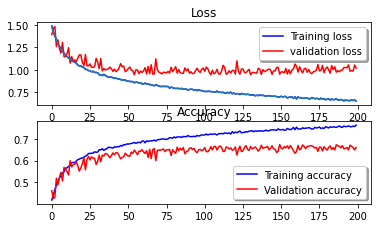

In [25]:
plot_acc(History)

In [26]:
predictions_val=model.predict(X_val)
predictions_train=model.predict(X_train)

In [27]:
def predict_(model,image):
    a = model.predict(np.array([X_val[6]]))
    s = np.argmax(a)
    return (emotions[s],a,s)

In [ ]:
#SimpleModel = Sequential([Conv2D(filters=16,kernel_size=(4,4),padding='same',activation='relu',input_shape=(48,48,1)),
#                         AvgPool2D(pool_size=(2)),
#                         BatchNormalization(),
#                         Conv2D(filters=16,kernel_size=(4,4),padding='same',activation='relu'),
#                         AvgPool2D(pool_size=(2)),
#                         BatchNormalization(),
#                         Flatten(),
#                         Dense(64,activation='relu'),
#                         Dense(32,activation='relu'),
#                         #Dropout(0.10),
#                         Dense(7,activation='softmax')])
#SimpleModel.summary()
#SimpleModel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#epoch = 200
#batch_size =512

#history3 = SimpleModel.fit_generator(datagen.flow(X_train,Y_train,batch_size),validation_data=(X_val,Y_val),epochs=epoch,steps_per_epoch=X_train.shape[0]//batch_size,verbose=2)

#history2 = SimpleModel.fit(X_train,Y_train,epochs=20,validation_data=(X_val,Y_val),verbose=2)

In [ ]:
#predictions_val = SimpleModel.predict(X_val)
#plot_acc(history3)
#plot_acc(history2)

Actual :  Fear


('Fear',
 array([[2.6052210e-02, 5.4673624e-04, 7.2147757e-01, 3.8604558e-04,
         4.6459576e-03, 2.4620362e-01, 6.8781810e-04]], dtype=float32),
 2)

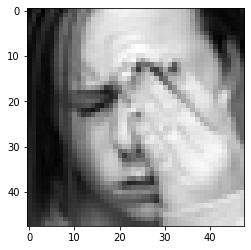

In [28]:
ind = randint(0,X_val.shape[0])
show_img(X_val,Y_val,ind)
predict_(model,X_val[ind])

In [29]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [34]:
id_val_pred=np.argmax(predictions_val,axis=1)
id_val_orig=np.argmax(Y_val,axis=1)

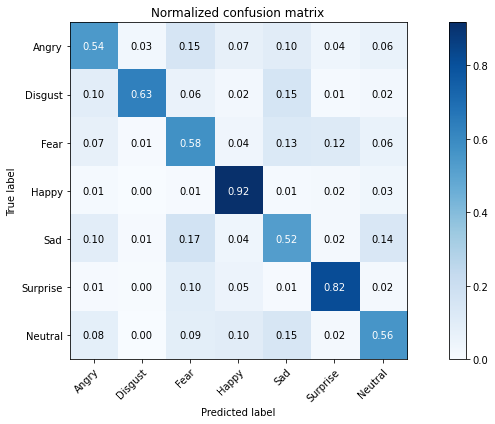

In [35]:
plot_confusion_matrix(id_val_pred, id_val_orig, classes=emotions, normalize=True, title='Normalized confusion matrix')
plt.show()